<a href="https://colab.research.google.com/github/cham2601/FDS-Language-Identification/blob/main/FDS_Lang_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Modeling

In [15]:
import numpy as np
import pandas as pd
import os

"""
Input: list of txt files - WA,FB,TW
Output: data - list containing appended data from all three files along with msg no: format - [[msgno,Word,Lang,Token]]
        msgsCnt - Total no of msgs
        cache - 3 index no's where WA,FB,TW data end
"""
def Edit(paths):
    msgsCnt=1
    data = []
    cache = ()
    numwords = 0
    i=-1
    for path in paths:
        f = open(path)
        while(True):
            line = f.readline()
            if line=="\n":
                msgsCnt += 1
                continue
            if line=="":
                break
            lin = [msgsCnt] + line.split()
            data.append(lin)
            numwords += 1
            if numwords == 50:
                numwords = 0
                msgsCnt += 1
            i += 1
        cache = cache + (i,)
    return data

# Retrieves paths from given folders and sends paths to edit
def Retrieve(folders):
    paths = []
    all_paths = []
    for folder in folders:
        list = []
        for file in os.listdir(folder):
            if file.endswith(".txt"):
                filepath = folder + "/" + file
                list.append(filepath)
                all_paths.append(filepath)
        paths.append(list)
    print(paths)
    data = {}
    # en_hi data
    data["en_hi"] = Edit(paths[0])
    # en_te data
    data["en_te"] = Edit(paths[1])
    # en_hi_te data
    data["en_hi_te"] = Edit(all_paths)
    for key,value in data.items():
        Create(value,key)
    return

# Creates csv files from cleaned data
def Create(data,name):
    df = pd.DataFrame(data,columns=["MsgNo", "Word", "Tag", "Token"])
    filename = name + ".csv"
    if os.path.exists(filename):
        os.remove(filename)
    df.to_csv(filename,index=False)
    return

In [16]:
"""
Run this cell and wait for a minute
You will get your data ready            :>)
"""
dir = ["en-hi","en-te"]
Retrieve(folders=dir)

[['en-hi/fb.txt', 'en-hi/tw.txt', 'en-hi/wa.txt'], ['en-te/fb.txt', 'en-te/tw.txt', 'en-te/wa.txt']]


# CRF classifier

### Importing sklearn model

In [87]:
!pip install sklearn_crfsuite

     |████████████████████████████████| 747kB 4.2MB/s 


In [89]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter

### Feature Extraction

In [90]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][2]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]
def sent2tags(sent):
    return [tag for word,tag,token in sent]

### Train test split

In [91]:
X = [sent2features(m) for m in messages]
Y = [sent2tags(m) for m in messages]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(X[0],"\n",y[0])

[{'bias': 1.0, 'word.lower()': '@bionicsix1', 'word[-3:]': 'ix1', 'word[-2:]': 'x1', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': '@', 'postag[:2]': '@', 'BOS': True, '+1:word.lower()': '@phanerozoic11', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'univ', '+1:postag[:2]': 'un'}, {'bias': 1.0, 'word.lower()': '@phanerozoic11', 'word[-3:]': 'c11', 'word[-2:]': '11', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': '@', 'postag[:2]': '@', '-1:word.lower()': '@bionicsix1', '-1:word.istitle()': False, '-1:word.isupper()': False, '-1:postag': 'univ', '-1:postag[:2]': 'un', '+1:word.lower()': '@pari_cious', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'univ', '+1:postag[:2]': 'un'}, {'bias': 1.0, 'word.lower()': '@pari_cious', 'word[-3:]': 'ous', 'word[-2:]': 'us', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'postag': '@', 'postag[:2]': '@

### Training

In [92]:
crf = sklearn_crfsuite.CRF(
    algorithm = 'lbfgs',
    c1 = 0.1,
    c2 = 0.1,
    max_iterations = 100,
    all_possible_transitions = True
)

crf.fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

### Evaluation

In [93]:
Y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(y_true=Y_test, y_pred = Y_pred, labels = tags))

              precision    recall  f1-score   support

          te       0.84      0.86      0.85      2526
          en       0.89      0.93      0.91      7724
           a       0.00      0.00      0.00         0
        acro       0.87      0.68      0.76        88
          ne       0.75      0.54      0.63       568
          hi       0.91      0.90      0.90      4463
        univ       0.88      0.84      0.86      5342
       mixed       0.00      0.00      0.00         6
       undef       0.00      0.00      0.00         1
          rn       0.00      0.00      0.00         0

   micro avg       0.88      0.88      0.88     20718
   macro avg       0.51      0.48      0.49     20718
weighted avg       0.88      0.88      0.88     20718



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Bi-LSTM Model

### Importing libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Pre-processing

In [54]:
data = pd.read_csv("en_hi_te.csv")
data

,MsgNo,Word,Tag,Token
0,1,@bionicsix1,univ,@
1,1,@phanerozoic11,univ,@
2,1,@pari_cious,univ,@
3,1,bohut,hi,G_SYM
4,1,achay,hi,G_J
...,...,...,...,...
70610,6022,heroine,en,G_N
70611,6022,kuda,te,G_X
70612,6022,rod,univ,G_N
70613,6022,ye,te,G_PRP


In [55]:
# drop rows if word is null
data.dropna(how="any",inplace=True)

In [56]:
print("total unique words in corpus:",data["Word"].nunique())
print("total unique langs in corpus:",data["Tag"].nunique())

total unique words in corpus: 17762
total unique langs in corpus: 10


In [57]:
data.groupby('Tag').count()

,MsgNo,Word,Token
Tag,,,
a,1,1,1
acro,353,353,353
en,26124,26124,26124
hi,15171,15171,15171
mixed,11,11,11
ne,1847,1847,1847
rn,1,1,1
te,8754,8754,8754
undef,3,3,3


In [72]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
tags = list(set(data["Tag"].values))
num_tags = len(tags)
print(words,"\n",tags,"\n",num_words,num_tags)

['chudochu', 'Bacchan', 'kraa', '@SohilPTI', 'weed', 'phle', 'KARTE', 'concentrated', 'Bhavesh', 'badolat', 'wil', 'favorite', 'AMEER', 'shivi', '@tufailelif', 'calling', 'provoke', '@ArvindKejriwal', 'frustration', 'few', '@DreamLike1D', 'salla', 'khuda', 'mickey', 'ami', 'impressed', 'Hoga', 'Hamari', 'choosaaraa', 'Punjabis', 'Kanche', 'Jara', '@huma_asghar2000', '@SreenuVaitla', 'gf', 'centiment', 'https://t.co/EONwqd8WAy', 'twitter.com/Premchandsayz/', 'nithin', 'Korangi', 'Tit', '@StarSportsIndia', 'manzil', 'duniya', 'itne', 'Theatre', 'Gautam', 'toys', 'visyam', 'unnayayyyo', 'Edit', 'Posani', 'nude', 'Kandhreega', 'cortando', 'intlo', 'kottaru', 'Hahah', 'bitwaa', '3002311931', 'inbox', 'Aaa', 'lafz', 'ministrs', 'widely', 'stupor', 'Aunty', 'interacted', 'phn', 'aayi', 'Ghotale', '#aus', '@rgvpuri', 'Graphic', 'boothu', '/707256173297164288', 'techukundi', '@zani_zain', 'Chamcha', 'dekhte', 'vastaav', 'matladadu', 'lae', 'srimantudu', 'Mann', '#Kushi', "Let's", 'wins', 'danki

In [73]:
func = lambda l: [(word,tag,tok) for word,tag,tok in zip(l["Word"].values,l["Tag"].values,l["Token"].values)]
groupedData = data.groupby("MsgNo").apply(func)
messages = [m for m in groupedData]

In [74]:
word_to_idx = {w : i for i,w in enumerate(words)}
idx_to_word = {i: w for i,w in enumerate(words)}
tag_to_idx = {t : i for i,t in enumerate(tags)}
idx_to_tag = {i : t for i,t in enumerate(tags)}
print(word_to_idx,"\n",idx_to_word,"\n",tag_to_idx)

{'chudochu': 0, 'Bacchan': 1, 'kraa': 2, '@SohilPTI': 3, 'weed': 4, 'phle': 5, 'KARTE': 6, 'concentrated': 7, 'Bhavesh': 8, 'badolat': 9, 'wil': 10, 'favorite': 11, 'AMEER': 12, 'shivi': 13, '@tufailelif': 14, 'calling': 15, 'provoke': 16, '@ArvindKejriwal': 17, 'frustration': 18, 'few': 19, '@DreamLike1D': 20, 'salla': 21, 'khuda': 22, 'mickey': 23, 'ami': 24, 'impressed': 25, 'Hoga': 26, 'Hamari': 27, 'choosaaraa': 28, 'Punjabis': 29, 'Kanche': 30, 'Jara': 31, '@huma_asghar2000': 32, '@SreenuVaitla': 33, 'gf': 34, 'centiment': 35, 'https://t.co/EONwqd8WAy': 36, 'twitter.com/Premchandsayz/': 37, 'nithin': 38, 'Korangi': 39, 'Tit': 40, '@StarSportsIndia': 41, 'manzil': 42, 'duniya': 43, 'itne': 44, 'Theatre': 45, 'Gautam': 46, 'toys': 47, 'visyam': 48, 'unnayayyyo': 49, 'Edit': 50, 'Posani': 51, 'nude': 52, 'Kandhreega': 53, 'cortando': 54, 'intlo': 55, 'kottaru': 56, 'Hahah': 57, 'bitwaa': 58, '3002311931': 59, 'inbox': 60, 'Aaa': 61, 'lafz': 62, 'ministrs': 63, 'widely': 64, 'stupor'

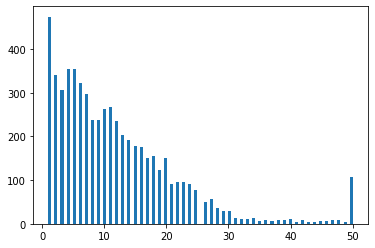

In [75]:
plt.hist([len(mess) for mess in messages],bins=100)
plt.show()

In [76]:
max([len(mess) for mess in messages])

50

### Feature Extraction

In [77]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50
x = [[word_to_idx[w[0]] for w in m] for m in messages]
x = pad_sequences(maxlen=max_len, sequences=x, padding="post", value=num_words-1)

y = [[tag_to_idx[w[1]] for w in m] for m in messages]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=9)
print([[idx_to_word[i] for i in l]for l in x])
print(x,x.shape,"\n",y,y.shape)

[['@bionicsix1', '@phanerozoic11', '@pari_cious', 'bohut', 'achay', 'ayay', '.', 'Mixed', 'dabay', 'Wala', 'mix', 'n', 'maida', '.', 'Apna', 'hee', 'koi', 'taste', 'bana', 'liya', ':)', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD'], ['listening', 'to', 'Ishq', 'Wala', 'Love', '(', 'From', '"', 'Student', 'of', 'the', 'Year', '"', ')', 'The', 'DJ', 'Suketu', 'Lounge', 'Mix', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD'], ['I', 'liked', 'a', '@YouTube', 'video', 'http://t.co/Y9edo1yfRN', '

### Train Test Split

In [78]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1)

### Bi-LSTM model

#### Building

In [79]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, TimeDistributed, SpatialDropout1D, Bidirectional
from keras.utils import to_categorical

input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=50, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 50)            888150    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 10)            2010      
Total params: 1,010,960
Trainable params: 1,010,960
Non-trainable params: 0
_________________________________________________________________


#### Compiling

In [80]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Training

In [81]:
!pip install livelossplot

In [82]:
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)
print(y_train[1],"\n",y_train_oh[1])

[6 5 1 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9] 
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0.

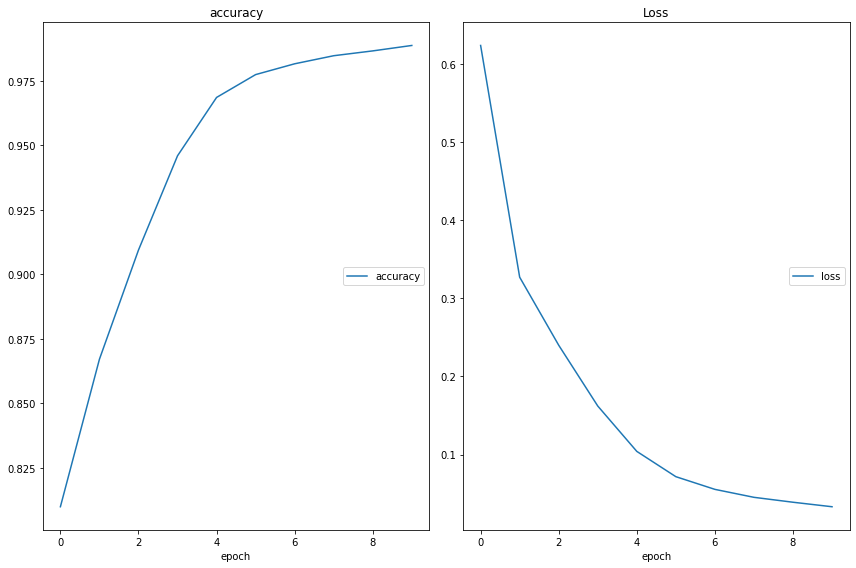

accuracy
	accuracy         	 (min:    0.810, max:    0.989, cur:    0.989)
Loss
	loss             	 (min:    0.033, max:    0.624, cur:    0.033)


In [83]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKeras

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesKeras(), chkpt, early_stopping]

model.fit(
    x=x_train,
    y=y_train_oh,
    # validation_data=(x_test,y_test_oh),
    batch_size=32, 
    epochs=3,
    callbacks=callbacks,
    verbose=True
)




####Evaluation

In [84]:
model.evaluate(x_test,y_test_oh)

56/56 [==============================] - 2s 25ms/step - loss: 0.1525 - accuracy: 0.9524


[0.1524561643600464, 0.9523777365684509]

#### Prediction

In [ ]:
y_pred_oh = model.predict(x_test)
y_pred = np.argmax(y_pred_oh,axis=-1)
y_pred = [[idx_to_tag[idx] for idx in pred]for pred in y_pred]
y_test = [[idx_to_tag[idx] for idx in test]for test in y_test]
print(metrics.flat_classification_report(y_true=y_test, y_pred = y_pred, labels = tags))